In [2]:
import os
import pandas as pd
import geopandas as gpd
import xarray as xr
import re
import h5py
from shapely import Point
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import richdem as rd

# Handling Rainfall Dataset

### Convert rainfall .nc4 to .cvs.gz

In [13]:
# Set input and output folders
input_folder = "datasets/Rainfall"
output_folder = "gpm_csv_florida"

In [125]:

os.makedirs(output_folder, exist_ok=True)

# Florida bounding box
lat_min, lat_max = 24.5, 31.0
lon_min, lon_max = -87.7, -79.8

# Regular expression to extract date
date_pattern = re.compile(r"(\d{8})")

# Loop through all .nc4 files
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith(".nc4"):
        file_path = os.path.join(input_folder, filename)

        # Extract date from filename
        match = date_pattern.search(filename)
        if not match:
            print(f"⚠️ Skipping (no date): {filename}")
            continue
        date_str = match.group(1)
        date_formatted = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"
        output_file = f"gpm_rainfall_{date_formatted}.csv"
        output_path = os.path.join(output_folder, output_file)

        try:
            # Open dataset
            ds = xr.open_dataset(file_path)

            # Get precipitation variable (time=0)
            if 'precipitation' in ds.variables:
                rain = ds['precipitation'].isel(time=0)
            elif 'precipitationCal' in ds.variables:
                rain = ds['precipitationCal'].isel(time=0)
            else:
                raise KeyError("No precipitation variable found in this file.")

            # Crop to Florida bounding box
            rain_fl = rain.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

            # Convert to DataFrame
            df = rain_fl.to_dataframe(name='rainfall').reset_index()
            df['date'] = date_formatted

            # Save to CSV
            df.to_csv(output_path, index=False)
            print(f"\r✔ Saved: {output_file}\r", end="")

            ds.close()

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")


### concatenate to a single csv file

In [98]:

# Input folder
input_folder = "gpm_csv_florida"

# Output CSV
output_file = "all_gpm_rainfall.csv"

# Flag to control writing header once
first_file = True

for filename in sorted(os.listdir(input_folder)):
    if filename.endswith(".csv") or filename.endswith(".csv.gz"):
        file_path = os.path.join(input_folder, filename)
        print(f"\rAppending: {filename}\r", end="")
        
        # Stream load
        for chunk in pd.read_csv(file_path, chunksize=100000):
            chunk.to_csv(output_file, mode='a', index=False, header=first_file)
            first_file = False

print(f"✅ Done! All files concatenated to {output_file}")



✅ Done! All files concatenated to all_gpm_rainfall.csv


### Spatial join with county shape

In [102]:
# rainfall = pd.read_csv("datasets/all_gpm_rainfall.csv")
counties = gpd.read_file("datasets/county_shape/tl_2024_us_county.shp").to_crs("EPSG:4326")
florida = counties[counties["STATEFP"] == "12"]
florida = florida[["GEOID", "geometry"]]

rainfall = gpd.GeoDataFrame(rainfall, 
                            geometry=gpd.points_from_xy(rainfall["longitude"], rainfall["latitude"]),
                            crs="EPSG:4326")
rainfall_counties = rainfall.sjoin(florida, how="inner", predicate="intersects")


In [104]:
rainfall_counties.to_csv("datasets/rainfall_counties.csv.gz", index=False, compression="gzip")

<Axes: >

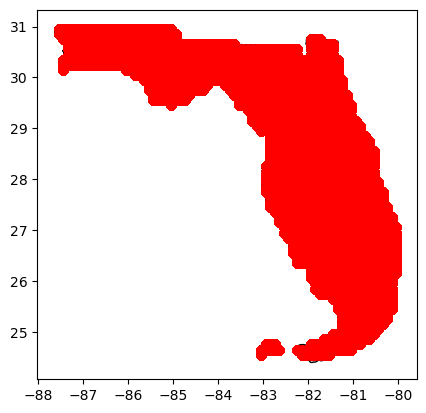

In [107]:
ax = florida.plot(edgecolor="black", facecolor='none')
rainfall_counties.plot(ax=ax, color="red")

# Handling Soil Moisture Dataset

### Converting to csv

In [139]:
# Root paths
input_root    = "datasets/smap"
output_folder = "datasets/soil_moisture"
os.makedirs(output_folder, exist_ok=True)

# Florida bounding box
lat_min, lat_max = 24.5, 31.0
lon_min, lon_max = -87.7, -79.8

# Columns to keep
cols = ['latitude', 'longitude', 'soil_moisture']

# Regex for date
date_pattern = re.compile(r"_([0-9]{8})_")

# Loop through .h5 files directly in root
for filename in sorted(os.listdir(input_root)):
    if not filename.endswith(".h5"):
        continue

    match = date_pattern.search(filename)
    if not match:
        print(f"⚠️ Skipping (no date): {filename}")
        continue

    date_str       = match.group(1)
    date_formatted = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"
    output_filename = f"smap_florida_{date_formatted}.csv.gz"
    output_path     = os.path.join(output_folder, output_filename)
    file_path       = os.path.join(input_root, filename)

    try:
        with h5py.File(file_path, "r") as f:
            group = f["Soil_Moisture_Retrieval_Data_AM"]

            data = {}
            for var_name, dset in group.items():
                if isinstance(dset, h5py.Dataset):
                    data[var_name] = dset[()].flatten()

            df = pd.DataFrame(data)
            df = df[cols]
            df = df[df['soil_moisture'] > -9999]

            # ✅ Crop to Florida
            df = df[
                (df['latitude'].between(lat_min, lat_max)) &
                (df['longitude'].between(lon_min, lon_max))
            ]
            df['date'] = date_formatted

        # ✅ Save as compressed CSV
        df.to_csv(output_path, index=False, compression="gzip")
        print(f"\r✔ Saved: {output_filename}\r", end="")

    except Exception as e:
        print(f"❌ Error processing {filename}: {e}")


✔ Saved: smap_florida_2025-01-01.csv.gz

### Concatenating into one tabular data

In [9]:
input_folder = "datasets/soil_moisture"
output_file = "datasets/all_soil_moisture.csv.gz"
first_file = True

for filename in sorted(os.listdir(input_folder)):
    if filename.endswith(".csv.gz"):
        
        filepath = os.path.join(input_folder, filename)
        print(f"\rAdding {filename}...\r", end="")

        try:
            for chunck in pd.read_csv(filepath, chunksize=100000):
                chunck.to_csv(output_file, mode='a', index=False, compression="gzip", header=first_file)
                first_file = False
        except Exception as e:
            print(f"Error Processing {filename}: {e}")

print("Merged All file successfully")
                          

Merged All file successfully01.csv.gz...


,latitude,longitude,soil_moisture,date
0,30.925072,-85.005190,0.179516,2015-04-01
1,30.925072,-84.911830,0.191564,2015-04-01
2,30.925072,-84.818470,0.207285,2015-04-01
3,30.925072,-84.725105,0.172415,2015-04-01
4,30.925072,-84.631744,0.176616,2015-04-01
...,...,...,...,...
2708099,25.256830,-80.897300,0.411062,2025-01-01
2708100,25.256830,-80.803940,0.442439,2025-01-01
2708101,25.256830,-80.710580,0.469371,2025-01-01
2708102,25.256830,-80.617220,0.412335,2025-01-01


### Spatial join with counties GEOID

In [108]:
counties = gpd.read_file("datasets/county_shape/tl_2024_us_county.shp").to_crs("EPSG:4326")
soil_moisture = pd.read_csv("datasets/all_soil_moisture.csv.gz")

florida = counties[counties["STATEFP"] == "12"]

florida = florida[["GEOID", "geometry"]]


In [109]:
soil_moisture = gpd.GeoDataFrame(soil_moisture, 
                                 geometry=gpd.points_from_xy(soil_moisture["longitude"], soil_moisture["latitude"]),
                                 crs="EPSG:4326")

In [110]:
soil_moisture = soil_moisture.drop(columns=["latitude", "longitude"])

In [84]:
soil_moisture

,soil_moisture,date,geometry
0,0.179516,2015-04-01,POINT (-85.00519 30.92507)
1,0.191564,2015-04-01,POINT (-84.91183 30.92507)
2,0.207285,2015-04-01,POINT (-84.81847 30.92507)
3,0.172415,2015-04-01,POINT (-84.7251 30.92507)
4,0.176616,2015-04-01,POINT (-84.63174 30.92507)
...,...,...,...
2708099,0.411062,2025-01-01,POINT (-80.8973 25.25683)
2708100,0.442439,2025-01-01,POINT (-80.80394 25.25683)
2708101,0.469371,2025-01-01,POINT (-80.71058 25.25683)
2708102,0.412335,2025-01-01,POINT (-80.61722 25.25683)


In [111]:
soil_moisture_counties = soil_moisture.sjoin(florida, how="inner", predicate="intersects")

In [112]:
n = soil_moisture_counties[soil_moisture_counties["GEOID"].isna()]

In [113]:
soil_moisture_counties

,soil_moisture,date,geometry,index_right,GEOID
0,0.179516,2015-04-01,POINT (-85.00519 30.92507),2580,12063
38,0.194009,2015-04-01,POINT (-85.00519 30.84308),2580,12063
76,0.236677,2015-04-01,POINT (-85.00519 30.76117),2580,12063
109,0.395620,2015-04-01,POINT (-81.92427 30.76117),2687,12089
110,0.435699,2015-04-01,POINT (-81.83091 30.76117),2687,12089
...,...,...,...,...,...
2708099,0.411062,2025-01-01,POINT (-80.8973 25.25683),1390,12087
2708100,0.442439,2025-01-01,POINT (-80.80394 25.25683),369,12086
2708101,0.469371,2025-01-01,POINT (-80.71058 25.25683),369,12086
2708102,0.412335,2025-01-01,POINT (-80.61722 25.25683),369,12086


<Axes: >

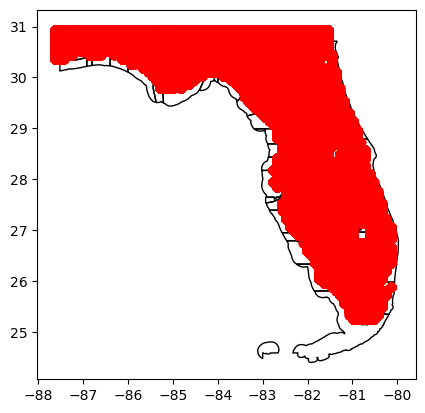

In [88]:
ax = florida.plot(edgecolor='black', facecolor='none')
soil_moisture.plot(ax=ax, color='red')

In [114]:
soil_moisture_counties.to_csv("datasets/soil_moisture_counties.csv.gz", index=False, compression="gzip")
    

# Handling NASADEM

### Merge elevation tiffs

In [80]:
!gdal_merge.py -o merged_output.tif -n -9999 -a_nodata -9999 datasets/NASADEM/output_be.tif datasets/NASADEM/output_be_2.tif


0...10...20...30...40...50...60...70...80...90...100 - done.


### Merge Slope tiffs

In [84]:
!gdal_merge.py -o merged_slope_output.tif -n -9999 -a_nodata -9999 datasets/NASADEM/viz.be_slope.tif datasets/NASADEM/viz.be_slope2.tif


0...10...20...30...40...50...60...70...80...90...100 - done.


### Using rainfall coordinates to get elevation

In [130]:
elevation_df = (pd.read_csv("datasets/joined_counties/rainfall_counties.csv.gz")
            .query('time < "2015-01-02"')
            .loc[:,['GEOID', 'longitude', 'latitude']]
           )

with rasterio.open("datasets/NASADEM/merged_elevation.tif") as src2:
    elevation = src2.read(1)
    transform = src2.transform
    elevation_df["elevation"] = elevation_df.apply(
        lambda row: get_elevation(elevation, transform, row['longitude'], row['latitude']),
        axis=1
    )

In [131]:
el = elevation_df

In [132]:
el

,GEOID,longitude,latitude,elevation
0,12033,-87.55,30.85,48
1,12033,-87.55,30.95,78
2,12033,-87.45,30.15,0
3,12033,-87.45,30.25,0
4,12033,-87.45,30.35,0
...,...,...,...,...
1694,12099,-80.05,26.65,6
1695,12099,-80.05,26.75,1
1696,12099,-80.05,26.85,8
1697,12099,-80.05,26.95,0


In [133]:
el = el[(el['elevation'] >=-50) & (el['elevation'] <=100)]



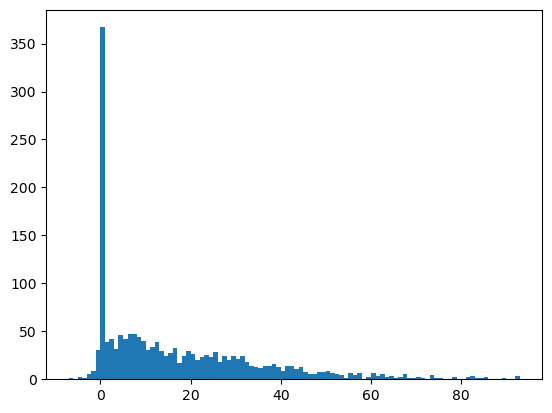

In [134]:
fig, ax = plt.subplots()
ax.hist(el['elevation'], bins=100)
plt.show()

In [135]:
final_elevation_counties = el.groupby('GEOID')['elevation'].agg(['min', 'max', 'mean', 'std'])

final_elevation_counties = final_elevation_counties.reset_index()
final_elevation_counties = final_elevation_counties.rename(columns={'min': 'elev_min',
                                                            'max': 'elev_max',
                                                            'mean': 'elev_mean',
                                                            'std': 'elev_std'
    
})

final_elevation_counties.to_csv("datasets/joined_counties/final_elevation_counties.csv", index=False)


### Handle slope

In [105]:
slope_df = (pd.read_csv("datasets/joined_counties/rainfall_counties.csv.gz")
            .query('time < "2015-01-02"')
            .loc[:,['GEOID', 'longitude', 'latitude']]
           )

with rasterio.open("datasets/NASADEM/merged_slope.tif") as src:
    slope = src.read(1)
    transform = src.transform
    slope_df["slope"] = slope_df.apply(
        lambda row: get_elevation(slope, transform, row['longitude'], row['latitude']),
        axis=1
    )

In [106]:
slope_df.to_csv("datasets/joined_counties/final_slope_counties.csv", index=False)

In [118]:
slope_df = slope_df[slope_df['slope'] > -9999]

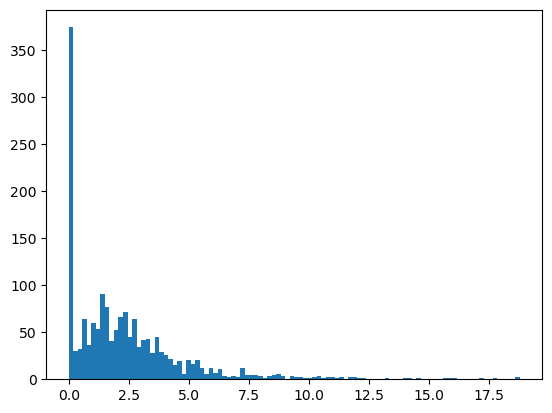

In [119]:
fig, ax = plt.subplots()
ax.hist(slope_df['slope'], bins=100)
plt.show()


In [136]:
final_slope = slope_df.groupby('GEOID')['slope'].agg(['min', 'max', 'mean', 'std'])

In [137]:
final_slope = final_slope.rename(columns={'min': 'slope_min',
                                                            'max': 'slope_max',
                                                            'mean': 'slope_mean',
                                                            'std': 'slope_std'
                                                                   })

final_slope  = final_slope .reset_index()


final_slope .to_csv("datasets/joined_counties/final_slope_counties.csv", index=False)

In [93]:
def get_elevation(elevation, transform, lon, lat):
    col = (lon - transform.c) / transform.a
    row = (transform.f - lat) / (-transform.e)
    
    col = int(round(col))
    row = int(round(row))

    if 0 <= row < elevation.shape[0] and 0 <= col < elevation.shape[1]:
        return elevation[row, col]
    else:
        return np.nan
    

In [ ]:
elevation_counties = elevation_counties[(elevation_counties['elevation'] >=-50) & (elevation_counties['elevation'] <=100)]

elevation_counties['elevation'].describe()

fig, ax = plt.subplots()
ax.hist(elevation_counties["elevation"], bins=100, range=(-10, 100))
plt.show()

final_elevation_counties = elevation_counties.groupby('GEOID')['elevation'].agg(['min', 'max', 'mean', 'std'])

final_elevation_counties = final_elevation_counties.rename(columns={'min': 'elev_min',
                                                            'max': 'elev_max',
                                                            'mean': 'elev_mean',
                                                            'std': 'elev_std'
    
})

final_elevation_counties = final_elevation_counties.reset_index()

final_elevation_counties

final_elevation_counties.to_csv("datasets/joined_counties/final_elevation_counties.csv", index=False)

In [52]:
def get_elevation(elevation, transform, lon, lat):
    col = (lon - transform.c) / transform.a
    row = (transform.f - lat) / (-transform.e)
    
    col = int(round(col))
    row = int(round(row))

    if 0 <= row < elevation.shape[0] and 0 <= col < elevation.shape[1]:
        return elevation[row, col]
    else:
        return np.nan
    

# Handle Flood events

In [300]:
import pandas as pd

def load_and_filter_storm_events(path):
    """
    Loads storm event data, filters for Florida (STATE_FIPS == 12),
    selects relevant columns, standardizes EVENT_TYPE,
    filters for flood events, and creates GEOID.
    """
    cols_to_keep = [
        'BEGIN_YEARMONTH', 'BEGIN_DAY', 'STATE_FIPS', 'CZ_FIPS',
        'EVENT_TYPE', 'FLOOD_CAUSE', 'BEGIN_LAT', 'BEGIN_LON'
    ]
    cols_to_drop = [ 'BEGIN_YEARMONTH', 'BEGIN_DAY', 'FLOOD_CAUSE', 'STATE_FIPS', 'CZ_FIPS', 'BEGIN_LAT', 'BEGIN_LON']
    
    df = (
        pd.read_csv(path)
          .query("STATE_FIPS == 12")
          .loc[:, cols_to_keep]
          .assign(EVENT_TYPE=lambda d: d['EVENT_TYPE'].str.lower())
          .query("EVENT_TYPE.str.contains('flood')", engine='python')
    )
    
    # Add GEOID column
    df['GEOID'] = (
        df['STATE_FIPS'].astype(str).str.zfill(2) +
        df['CZ_FIPS'].astype(str).str.zfill(3)
    )

    df['date'] = pd.to_datetime(
        df['BEGIN_YEARMONTH'].astype(str) + df['BEGIN_DAY'].astype(str).str.zfill(2),
        format='%Y%m%d',
        errors='coerce'
    )
    
    df = df.drop(columns=cols_to_drop)
    return df


In [303]:
input_folder = "datasets/storm_events"


data = pd.DataFrame()
for filename in sorted(os.listdir(input_folder)):

    if filename.endswith(".csv") or filename.endswith(".csv.gz"):

        filepath = os.path.join(input_folder, filename)
        
        df = load_and_filter_storm_events(filepath)
        data = pd.concat([data, df])

In [305]:
data.to_csv("datasets/joined_counties/flood_events.csv", index=False)

In [47]:
data

,EVENT_TYPE,GEOID,date
375,coastal flood,12125,2015-12-05
563,flood,12087,2015-08-03
7934,flood,12057,2015-08-01
11779,flood,12017,2015-08-01
13330,flood,12101,2015-07-24
...,...,...,...
67500,flood,12031,2024-09-09
68223,flash flood,12031,2024-09-04
68429,flash flood,12031,2024-09-04
68430,flash flood,12031,2024-09-05


# Merge Everything together

In [41]:
slope_df = pd.read_csv("datasets/joined_counties/final_slope_counties.csv")
elev_df = pd.read_csv("datasets/joined_counties/final_elevation_counties.csv")
rainfall_df = pd.read_csv("datasets/joined_counties/rainfall_counties.csv.gz")
soil_moisture_df = pd.read_csv("datasets/joined_counties/soil_moisture_counties.csv.gz")
flood_events_df = pd.read_csv("datasets/joined_counties/flood_events.csv")

In [363]:
soil_features = elev_df.merge(slope_df, how="right", on='GEOID')

In [364]:
soil_features

,GEOID,elev_min,elev_max,elev_mean,elev_std,slope_min,slope_max,slope_mean,slope_std
0,12001,12,62,32.761905,12.895366,1.312327,16.027782,6.384000,4.614730
1,12003,20,57,37.761905,9.575514,0.328135,18.791857,7.266035,4.907126
2,12005,0,60,8.764706,14.116526,0.000000,5.646210,1.237601,1.635382
3,12007,26,62,47.000000,11.608187,1.995185,18.652594,8.575645,5.832273
4,12009,-2,25,4.170732,5.490457,0.000000,5.174222,1.286302,1.370454
...,...,...,...,...,...,...,...,...,...
62,12125,19,43,33.800000,10.183320,3.022486,14.101502,8.124914,4.005695
63,12127,-5,27,8.750000,7.972721,0.000000,6.106912,2.321718,1.863677
64,12129,0,29,10.772727,10.018705,0.000000,5.966317,1.835341,1.916657
65,12131,0,85,34.416667,30.319607,0.000000,4.687748,1.821154,1.472121


In [42]:
rainfall_df = rainfall_df[['GEOID', 'rainfall', 'date']]


In [40]:
rainfall_df['rainfall_rounded'] = round(rainfall_df['rainfall'])

<Axes: >

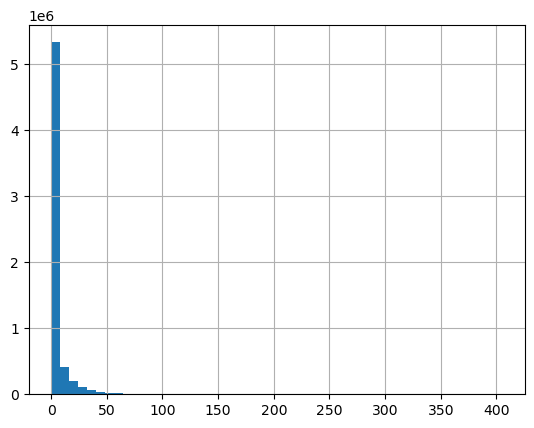

In [37]:
rainfall_df['rainfall_rounded'].hist(bins=50)

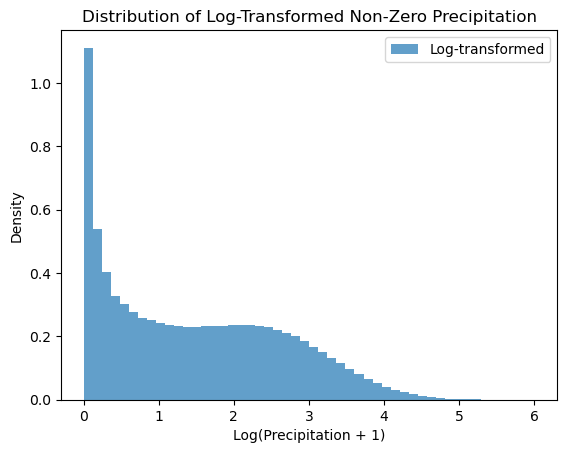

Gamma distribution parameters: shape=0.4433551502488404, scale=18.039190224902658


NameError: name 'data' is not defined

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load IMERG data (assuming a CSV with daily precipitation)

precip = rainfall_df['rainfall']  # Daily precipitation in mm

# Handle zeros and non-zeros separately
is_rainy = (precip > 0).astype(int)  # Binary indicator for rain
nonzero_precip = precip[precip > 0]  # Non-zero precipitation values

# Log-transform non-zero values
log_nonzero_precip = np.log1p(nonzero_precip)

# Visualize distribution
plt.hist(log_nonzero_precip, bins=50, density=True, alpha=0.7, label='Log-transformed')
plt.title('Distribution of Log-Transformed Non-Zero Precipitation')
plt.xlabel('Log(Precipitation + 1)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Fit a gamma distribution to non-zero precipitation
shape, loc, scale = gamma.fit(nonzero_precip, floc=0)  # Fix location to 0
print(f"Gamma distribution parameters: shape={shape}, scale={scale}")

# Example: Train a Random Forest to predict rainy days
X = rain[['temperature', 'humidity', 'pressure']]  # Example features
y = is_rainy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
print(f"Model accuracy: {model.score(X_test, y_test)}")

In [397]:
rainfall_df = rainfall_df.groupby(["GEOID", "date"], as_index=False)['rainfall'].sum()

In [399]:
print(rainfall_df[rainfall_df['rainfall']== rainfall_df['rainfall'].max()])

        GEOID        date     rainfall
157967  12087  2017-06-07  11811.97978


<Axes: >

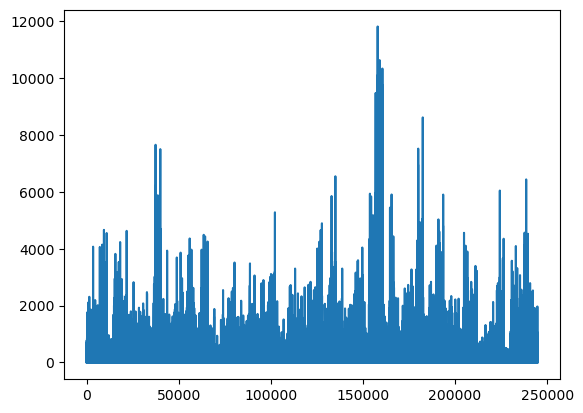

In [393]:
rainfall_df['rainfall'].plot()

In [368]:
soil_moisture_df = soil_moisture_df[['GEOID', 'soil_moisture', 'date']]

In [369]:
soil_moisture_df = soil_moisture_df.groupby(["GEOID", "date"], as_index=False)['soil_moisture'].mean()

In [370]:
soil_moisture_df

,GEOID,date,soil_moisture
0,12001,2015-04-01,0.154073
1,12001,2015-04-04,0.149908
2,12001,2015-04-06,0.182036
3,12001,2015-04-07,0.178972
4,12001,2015-04-09,0.159802
...,...,...,...
103215,12133,2024-12-19,0.279998
103216,12133,2024-12-22,0.245652
103217,12133,2024-12-25,0.222334
103218,12133,2024-12-27,0.274217


In [371]:
flood_events_df

,EVENT_TYPE,GEOID,date
0,coastal flood,12125,2015-12-05
1,flood,12087,2015-08-03
2,flood,12057,2015-08-01
3,flood,12017,2015-08-01
4,flood,12101,2015-07-24
...,...,...,...
1775,flood,12031,2024-09-09
1776,flash flood,12031,2024-09-04
1777,flash flood,12031,2024-09-04
1778,flash flood,12031,2024-09-05


In [372]:
soil_rain = soil_moisture_df.merge(rainfall_df, how="inner", on=['GEOID', 'date'])

In [373]:
soil_rain_elev = soil_rain.merge(soil_features, how="inner", on="GEOID")

In [374]:
soil_rain_elev

,GEOID,date,soil_moisture,rainfall,elev_min,elev_max,elev_mean,elev_std,slope_min,slope_max,slope_mean,slope_std
0,12001,2015-04-01,0.154073,0.225000,12,62,32.761905,12.895366,1.312327,16.027782,6.3840,4.614730
1,12001,2015-04-04,0.149908,40.025000,12,62,32.761905,12.895366,1.312327,16.027782,6.3840,4.614730
2,12001,2015-04-06,0.182036,46.364998,12,62,32.761905,12.895366,1.312327,16.027782,6.3840,4.614730
3,12001,2015-04-07,0.178972,13.530000,12,62,32.761905,12.895366,1.312327,16.027782,6.3840,4.614730
4,12001,2015-04-09,0.159802,0.180000,12,62,32.761905,12.895366,1.312327,16.027782,6.3840,4.614730
...,...,...,...,...,...,...,...,...,...,...,...,...
103156,12133,2024-12-19,0.279998,0.000000,12,82,29.937500,16.639186,1.037553,5.444872,2.8522,1.401803
103157,12133,2024-12-22,0.245652,0.000000,12,82,29.937500,16.639186,1.037553,5.444872,2.8522,1.401803
103158,12133,2024-12-25,0.222334,20.055000,12,82,29.937500,16.639186,1.037553,5.444872,2.8522,1.401803
103159,12133,2024-12-27,0.274217,0.000000,12,82,29.937500,16.639186,1.037553,5.444872,2.8522,1.401803


In [375]:
all_data = soil_rain_elev.merge(flood_events_df, how="left", on=["GEOID", "date"])

In [376]:
all_data["flooded"] = all_data["EVENT_TYPE"].notna().astype(int)

In [377]:
all_data['flooded'].value_counts()

flooded
0    102780
1       624
Name: count, dtype: int64

In [378]:
all_data = all_data.drop('EVENT_TYPE', axis=1)

In [379]:
all_data.to_csv("florida_flood_dataset.csv", index=False)

In [380]:
all_data.columns

Index(['GEOID', 'date', 'soil_moisture', 'rainfall', 'elev_min', 'elev_max',
       'elev_mean', 'elev_std', 'slope_min', 'slope_max', 'slope_mean',
       'slope_std', 'flooded'],
      dtype='object')